# Import Required Libraries

In [1]:
import re
import random
import numpy as np
import pandas as pd
import spacy
import gensim
from gensim.utils import tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.parsing.preprocessing import (remove_stopwords, strip_punctuation, lower_to_unicode, strip_numeric, strip_short,
                                          strip_tags, strip_non_alphanum, split_alphanum, stem_text, strip_multiple_whitespaces)
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import tqdm
from scipy.spatial.distance import jensenshannon, jaccard

# Load Dataset

In [3]:
df = pd.read_excel("dataset.xlsx")
num_doc = df.shape[0]
df.columns = ['title', 'abstract', 'publish_year']
df['doc_id'] = range(num_doc)
df['text'] = df["title"].str.cat(df["abstract"], sep=" ")
texts = df['text']

# Number of papers published by year

In [4]:
publish_year = df['publish_year'].to_numpy()
unique_frequency = np.unique(publish_year, return_counts=True)
fig = plt.figure(figsize=(8,4),dpi=100)
plt.plot(unique_frequency[0], unique_frequency[1])
plt.xlabel("Year of publication")
plt.ylabel("Number of papers")

Text(0, 0.5, 'Number of papers')

# Pre-processing Documents

In [5]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def lemmatization(texts):
    allowed_postags = ["NOUN", "ADJ", "VERB", "ADV"]
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return texts_out

def document_preprocessing(docs, flag=True):
    # Lower-casing
    docs = [lower_to_unicode(doc) for doc in docs]
    # Add spaces between digits & letters
    docs = [split_alphanum(doc) for doc in docs]
    # Remove non-alphabetic characters
    docs = [strip_non_alphanum(doc) for doc in docs]
    # Remove Punctuations
    docs = [strip_punctuation(doc) for doc in docs]
    # Remove Numbers
    docs = [strip_numeric(doc) for doc in docs]
    # Remove tags
    docs = [strip_tags(doc) for doc in docs]
    # Remove stopwords
    docs = [remove_stopwords(doc) for doc in docs]
    # Stemming
    docs = [stem_text(doc) for doc in docs]
    # Remove words with length lesser than minsize
    docs = [strip_short(doc, minsize=3) for doc in docs]
    # Remove repeating whitespace characters
    docs = [strip_multiple_whitespaces(doc) for doc in docs]
    # Remove words like aaa, bbb, aaai, aaaa, aaaaa for [a-z]
    docs = [re.sub(r'\b\w*?([a-z])\1\1\w*\b', '', doc) for doc in docs]
    # Document Tokenizing
    if flag:
        tokens = [list(tokenize(doc, lower=True)) for doc in docs]
    else:
        tokens = docs
    return tokens

def make_bigrams(tokens):
    bigram_phrases = gensim.models.Phrases(tokens, min_count=20, threshold=0.1, scoring="npmi")
    bigram = gensim.models.phrases.Phraser(bigram_phrases)
    return [bigram[doc] for doc in tokens]

# Corpus Design and Compute Model Metrics

In [6]:
def create_corpus_dictionary(tokens, no_below=20, no_above=0.01):
    dictionary = corpora.Dictionary(tokens)
    dictionary.filter_extremes(no_below=no_below, no_above=no_above)
    corpus = [dictionary.doc2bow(text) for text in tokens]
    tfidf = gensim.models.TfidfModel(corpus=corpus)
    corpus_tfidf = tfidf[corpus]
    return dictionary, corpus_tfidf

def compute_stability_coincidence(model1, model2, t):
    num_topic = model1.num_topics
    AJ_matrix = np.zeros((num_topic, num_topic))
    for i in range(num_topic):
        for j in range(num_topic):
            jac_d = 0
            for k in range(t):
                R1 = list(dict(model1.show_topic(i,k+1)).keys())
                R2 = list(dict(model2.show_topic(j,k+1)).keys())
                d = 1 - jaccard(R1,R2)
                jac_d += d
            AJ_matrix[i,j] = jac_d/t
    stability = np.sum(np.apply_along_axis(lambda x: x.max(), 0, AJ_matrix))/num_topic
    coincidence_sum = np.sum(AJ_matrix > 0, axis=0)
    num_coincidence = np.sum(coincidence_sum > 0)
    coincidence = np.sum(coincidence_sum/num_coincidence)
    return stability, coincidence

def compute_isolation(model):
    topics_terms_proba = np.apply_along_axis(lambda x: x/x.sum(), 1, model.state.get_lambda())
    s_ave = np.apply_along_axis(lambda x: x.mean(), 0, topics_terms_proba)
    sigma = 0
    for i in range(model.num_topics):
        sigma += jensenshannon(topics_terms_proba[i,:], s_ave)**2
    sigma_js = np.sqrt(sigma/model.num_topics)
    return sigma_js

# Document lemmatization

In [38]:
# Document Preprocessing
lemmatized_texts = lemmatization(texts)

# Word Cloud of 1000 frequent terms

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

docs = document_preprocessing(lemmatized_texts, flag=False)
vectorizer1 = TfidfVectorizer(min_df=5)
vectorizer2 = CountVectorizer(min_df=5)

tfidf_corpus = vectorizer1.fit_transform(docs)
count_corpus = vectorizer2.fit_transform(docs)

vocab = vectorizer1.get_feature_names_out()
word_freq_tfidf = pd.DataFrame()
word_freq_tfidf["id"] = vocab
word_freq_tfidf["freq"] = np.sum(count_corpus, axis=0).transpose()
word_freq_tfidf["tfidf"] = np.sum(tfidf_corpus, axis=0).transpose()
word_freq_tfidf.sort_values(by='freq', ascending=False).to_csv("word_freq_tfidf.csv")
word_freq_dict = dict(zip(word_freq_tfidf.id, word_freq_tfidf.freq))

In [21]:
pd.DataFrame(count_corpus.toarray())

0     1     2     3     4     5     6     7     8     9     ...  5571  \
0         0     0     0     0     0     0     0     0     0     0  ...     0   
1         0     0     0     0     0     0     0     0     0     0  ...     0   
2         0     0     0     0     0     0     0     0     0     0  ...     0   
3         0     0     0     0     0     0     0     0     0     0  ...     0   
4         0     0     0     0     0     0     0     0     0     0  ...     0   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
11348     0     0     0     0     0     0     0     0     0     0  ...     0   
11349     0     0     0     0     0     0     0     0     0     0  ...     0   
11350     0     0     0     0     0     0     0     0     0     0  ...     0   
11351     0     0     0     0     0     0     0     0     0     0  ...     0   
11352     0     0     0     0     0     0     0     0     0     0  ...     0   

       5572  5573  5574  5575  5576  5577  5578  5579  5580  
0         1     0     0     0     0     0     0     0     0  
1         0     0     0     0     0     0     0     0     0  
2         1     0     0     0     0     0     0     0     0  
3         0     0     0     0     0     0     0     0     0  
4         2     0     0     0     0     0     0     0     0  
...     ...   ...   ...   ...   ...   ...   ...   ...   ...  
11348     0     0     0     0     0     0     0     0     0  
11349     0     0     0     0     0     0     0     0     0  
11350     0     0     0     0     0     0     0     0     0  
11351     0     0     0     0     0     0     0     0     0  
11352     0     0     0     0     0     0     0     1     0  

[11353 rows x 5581 columns]

# Show part of document-term matrix

In [140]:
dense_corpus_df = pd.DataFrame(tfidf_corpus.toarray(), columns=vocab)
column = ["research","develop","studi","univers","relationship","collabor","technolog","educ","knowledg","process","academ","paper"]
part_corpus = dense_corpus_df[column]
part_corpus.to_csv("part_corpus.csv")
part_corpus

research   develop     studi   univers  relationship  collabor  \
0      0.093676  0.000000  0.000000  0.000000      0.000000   0.00000   
1      0.000000  0.000000  0.000000  0.000000      0.027344   0.03181   
2      0.256898  0.118452  0.000000  0.141767      0.000000   0.00000   
3      0.016093  0.017314  0.000000  0.015542      0.000000   0.00000   
4      0.191256  0.000000  0.093476  0.000000      0.000000   0.00000   
...         ...       ...       ...       ...           ...       ...   
11348  0.016312  0.000000  0.079723  0.031505      0.020146   0.00000   
11349  0.000000  0.000000  0.000000  0.022063      0.056431   0.00000   
11350  0.031795  0.000000  0.031080  0.015353      0.019634   0.00000   
11351  0.015841  0.000000  0.046452  0.000000      0.019564   0.00000   
11352  0.000000  0.000000  0.000000  0.040497      0.000000   0.00000   

       technolog  educ  knowledg   process    academ     paper  
0       0.000000   0.0  0.000000  0.000000  0.000000  0.000000  
1       0.000000   0.0  0.000000  0.033542  0.000000  0.000000  
2       0.056380   0.0  0.000000  0.000000  0.000000  0.000000  
3       0.024723   0.0  0.024486  0.000000  0.000000  0.000000  
4       0.000000   0.0  0.000000  0.000000  0.149063  0.000000  
...          ...   ...       ...       ...       ...       ...  
11348   0.000000   0.0  0.000000  0.000000  0.228837  0.019793  
11349   0.000000   0.0  0.000000  0.034611  0.320504  0.000000  
11350   0.000000   0.0  0.000000  0.000000  0.000000  0.019290  
11351   0.000000   0.0  0.000000  0.023998  0.000000  0.000000  
11352   0.000000   0.0  0.000000  0.000000  0.000000  0.000000  

[11353 rows x 12 columns]

In [117]:
from nltk.corpus import stopwords
from wordcloud import WordCloud
stop_words = stopwords.words('english')

cloud = WordCloud(stopwords=stop_words,
                  background_color="white",
                  width=4000,
                  height=1800,
                  max_words=1000).generate_from_frequencies(word_freq_dict)

E:\My projects\LDA Project\python_codes\venv\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


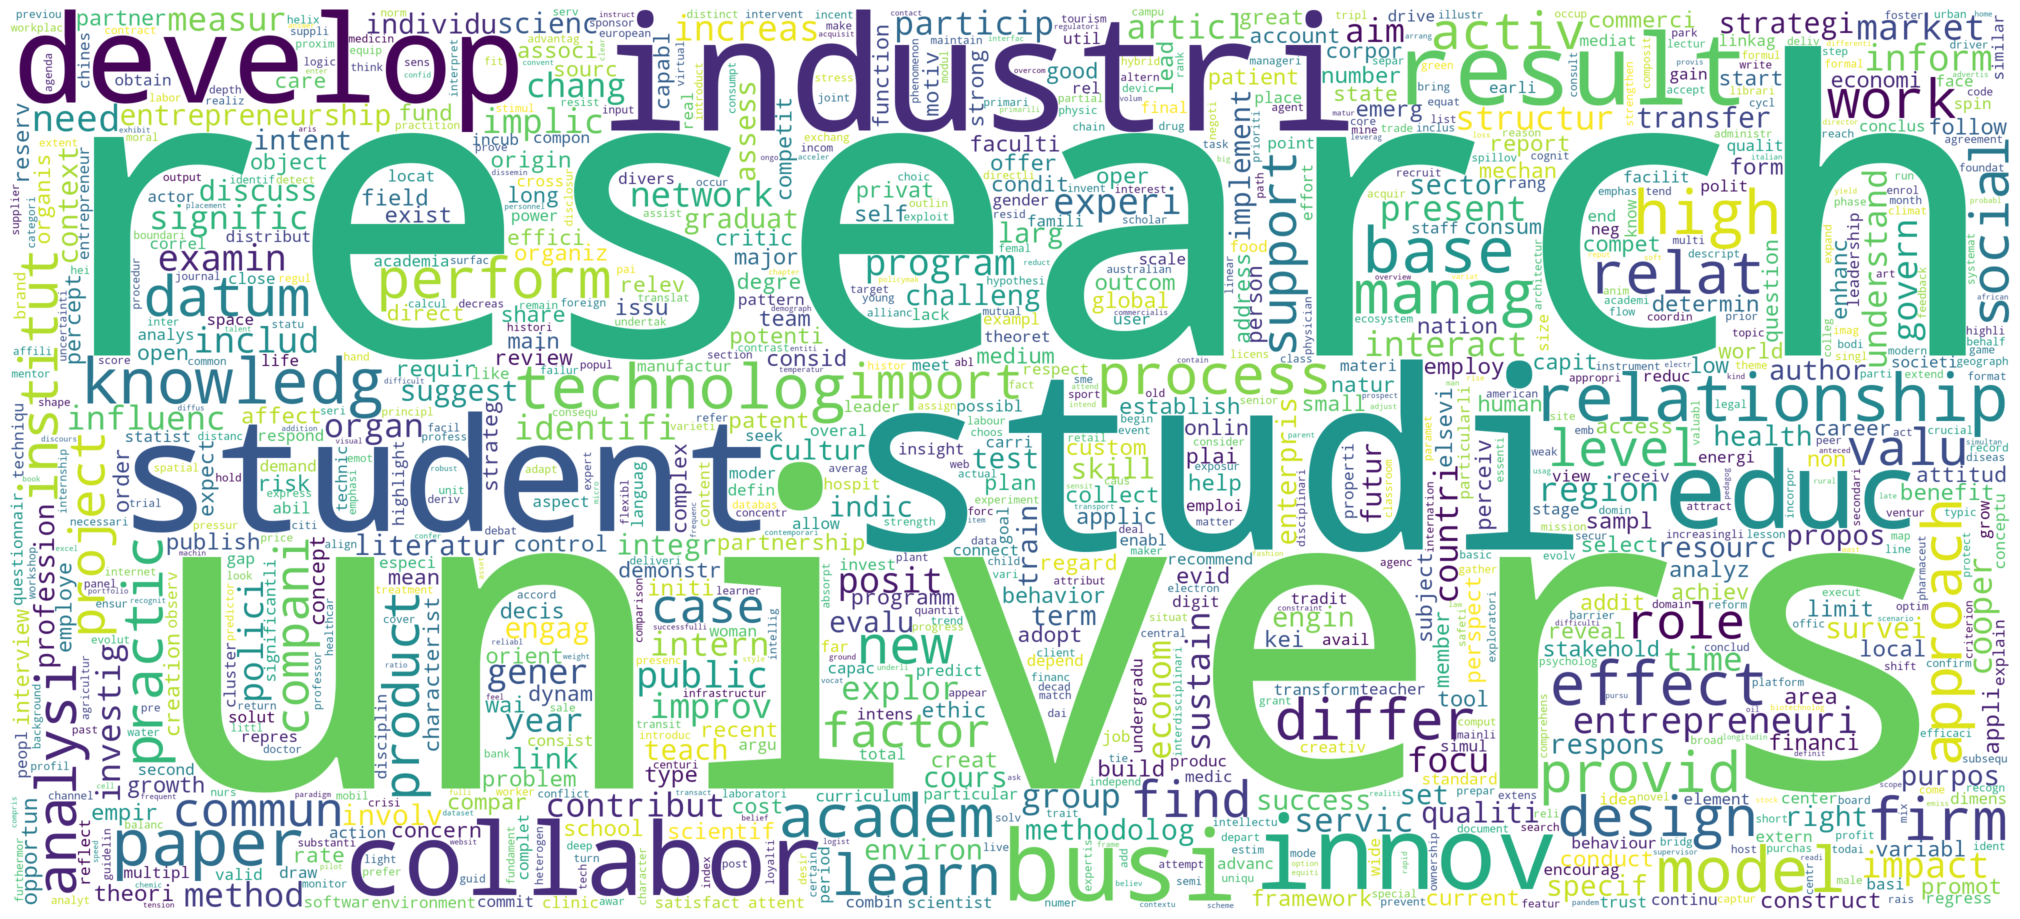

In [118]:
plt.figure(figsize=[20,10])
plt.imshow(cloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Add bigrams to dictionary

In [39]:
tokens = document_preprocessing(lemmatized_texts, flag=True)
tokens = make_bigrams(tokens)

# Find optimal number of topics

In [10]:
num_doc = len(tokens)
train = tokens

# Create Corpus and Dictionary of train-set
train_dictionary, train_corpus = create_corpus_dictionary(train)

# List of number of topics
num_topics = np.arange(4, 51, 2)
num_sampling = 15
sampling_rate = 0.8
sampling_split = int(sampling_rate * len(train))

complete_models = []
sample_models = []
topic_scores = []
stability_average = []      # Store stability average for each number of topics
coincidence_average = []    # Store coincidence average for each number of topics
isolation_average = []      # Store isolation average for each number of topics
perplexity_average = []     # Store perplexity average for each number of topics

pbar = tqdm.tqdm(total=int(num_sampling*len(num_topics)))

for i in range(len(num_topics)):
    # Generate LDA-Model Based on the Complete Train Data-set
    model_h0 = gensim.models.ldamodel.LdaModel(corpus=train_corpus, num_topics=num_topics[i], random_state=100, passes=30, iterations=400,
                                        alpha=0.1, eta=0.01, id2word=train_dictionary, per_word_topics=True, minimum_probability=0)
    complete_models.append(model_h0)

    sample_model = []           # Store Generated LDA-model of sampled data
    stability = []              # Store Stability within sampling
    coincidence = []            # Store Coincidence within sampling
    isolations = []             # Store isolation within sampling
    perplexities = []           # Store perplexity within sampling
    sampling_score = []         # Store sampling score that compute from isolation, stability, perplexity and coincidence

    # Sampling
    for j in range(num_sampling):
        # Shuffle data to sample from it!
        random.shuffle(train)
        train_set = train[:sampling_split]
        test_set = train[sampling_split:]

        # Create sampled data dictionary and corpus
        train_dictionary_sampling, train_corpus_sampling = create_corpus_dictionary(train_set)
        test_dictionary_sampling, test_corpus_sampling = create_corpus_dictionary(train_set)

        # Generate LDA-model of sampled data
        model_h1 = gensim.models.ldamodel.LdaModel(corpus=train_corpus_sampling, num_topics=num_topics[i], random_state=100, passes=30, iterations=400,
                                                   alpha=0.1, eta=0.01, id2word=train_dictionary_sampling, per_word_topics=True, minimum_probability=0)

        s, c = compute_stability_coincidence(model_h0, model_h1, 15)
        isolation =  compute_isolation(model_h1)
        perplexity = model_h1.log_perplexity(test_corpus_sampling)
        score = -(perplexity * c)/(isolation * s)

        sample_model.append(model_h1)
        stability.append(s)
        coincidence.append(c)
        isolations.append(isolation)
        perplexities.append(perplexity)
        sampling_score.append(score)
        pbar.update(1)

    stability_average.append(np.mean(stability))
    coincidence_average.append(np.mean(coincidence))
    isolation_average.append(np.mean(isolations))
    perplexity_average.append(np.mean(perplexities))
    topic_score = np.mean(sampling_score)
    topic_scores.append(topic_score)
    sample_models.append(sample_model)

100%|██████████| 360/360 [5:51:58<00:00, 58.73s/it]  

# Compute Coherence score for different number of topics

In [11]:
coherence_values = []
for i in range(len(num_topics)):
    model = complete_models[i]
    coherence_model = gensim.models.CoherenceModel(model=model, corpus=train_corpus, dictionary=train_dictionary, texts=train, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())

In [21]:
find_num_topic_df = pd.DataFrame({"num_topics": num_topics,
                                  "coherence_value": coherence_values,
                                  "perplexity": perplexity_average,
                                  "topic_score": topic_scores})
find_num_topic_df.to_csv("find_num_topic_df.csv")
find_num_topic_df

num_topics  coherence_value  perplexity  topic_score
0            4         0.466380   -9.523712   237.304728
1            6         0.520762   -9.866168   306.545708
2            8         0.515892  -10.104819   311.295193
3           10         0.523881  -10.255420   347.432332
4           12         0.524115  -10.411166   260.054573
5           14         0.542320  -10.493996   274.443927
6           16         0.543933  -10.591283   242.321354
7           18         0.544410  -10.652540   201.169759
8           20         0.558228  -10.718558   240.205297
9           22         0.549999  -10.784660   204.765864
10          24         0.562662  -10.854369   240.679120
11          26         0.552246  -10.915603   225.768195
12          28         0.563196  -10.929875   224.385831
13          30         0.563198  -10.962726   252.203677
14          32         0.574122  -11.014544   231.776125
15          34         0.569184  -11.050543   228.159237
16          36         0.572099  -11.057826   219.807942
17          38         0.574424  -11.086564   218.245498
18          40         0.581395  -11.134471   214.456918
19          42         0.565715  -11.143767   212.126722
20          44         0.573229  -11.148923   234.517431
21          46         0.571838  -11.203578   223.647654
22          48         0.581815  -11.177790   229.015112
23          50         0.579012  -11.208046   220.319291

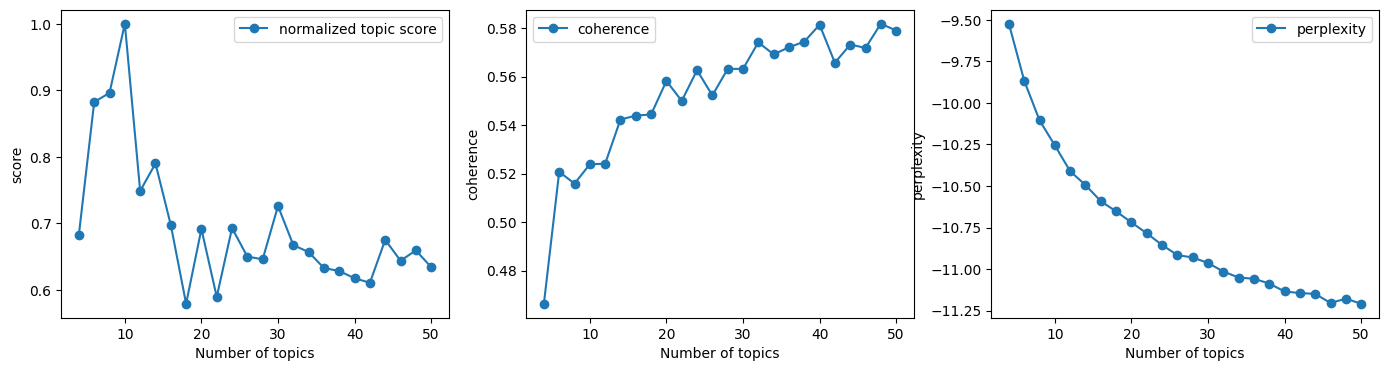

In [12]:
plt.figure(figsize=(17,4), dpi=100)
plt.subplot(1,3,1)
plt.plot(num_topics, np.array(topic_scores)/max(topic_scores),'o-', label="normalized topic score")
plt.xlabel("Number of topics")
plt.ylabel("score")
plt.legend()

plt.subplot(1,3,2)
plt.plot(num_topics, coherence_values,'o-',label="coherence")
plt.xlabel("Number of topics")
plt.ylabel("coherence")
plt.legend()

plt.subplot(1,3,3)
plt.plot(num_topics, perplexity_average,'o-',label="perplexity")
plt.xlabel("Number of topics")
plt.ylabel("perplexity")
plt.legend()

# Best Model

In [40]:
# Create Corpus and Dictionary of train-set
train_dictionary, train_corpus = create_corpus_dictionary(tokens)
model = gensim.models.ldamodel.LdaModel(corpus=train_corpus, num_topics=18, random_state=100, passes=30, iterations=400,
                                        alpha=0.1, eta=0.01, id2word=train_dictionary, per_word_topics=True, minimum_probability=0)
coherence_model = gensim.models.CoherenceModel(model=model, corpus=train_corpus, dictionary=train_dictionary, texts=tokens, coherence='c_v')
coherence_value = coherence_model.get_coherence()
print("Coherence value of best model: ", coherence_value)

Coherence value of best model:  0.5444103815948652


# Dominant topic and its percentage contribution in each document

In [22]:
def topic_documents(model=None, corpus=None, text=None):
    doc_topics = []
    for i, row_list in enumerate(model[corpus]):
        row = row_list[0] if model.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Dominant Topics
                wp = model.show_topic(topic_num,15)
                topic_keywords =", ".join([word for word, prep in wp])
                doc_topics.append([int(topic_num), topic_keywords, round(prop_topic,4)])
            else:
                break
    doc_topics_df = pd.DataFrame(doc_topics, columns=['Dominant_topic', 'Topic_keywords', 'Topic_perc_contrib'])
    all_doc_topics = doc_topics_df
    doc_topics_df = doc_topics_df.groupby('Dominant_topic', as_index=False)['Topic_keywords'].value_counts()
    doc_topics_df.columns = ['Dominant_topic', 'Topic_keywords', 'Number_of_documents']
    doc_topics_df['percentage_of_topic_documents'] = doc_topics_df.apply(lambda x: x['Number_of_documents']/len(corpus), axis=1)
    contents = pd.Series(text)
    all_doc_topics = pd.concat([all_doc_topics, contents], axis=1)
    all_doc_topics.columns = ['Dominant_topic', 'Topic_keywords', 'Topic_perc_contrib', 'text']
    return all_doc_topics, doc_topics_df

all_doc_topics, df_topic_documents_keywords= topic_documents(model=model, corpus=train_corpus, text=tokens)

In [24]:
df_topic_documents_keywords.to_csv("df_topic_documents_keywords.csv")
all_doc_topics.to_csv("all_doc_topics.csv")
df_topic_documents_keywords

Dominant_topic                                     Topic_keywords  \
0                0  region_innov, research_cooper, portfolio, cata...   
1                1  social_capit, librarian, cope, particl, logist...   
2                2  absorpt_capac, startup, firm_innov, high_tech,...   
3                3  nurs, disclosur, emiss, climat_chang, physicia...   
4                4  suppli_chain, subject_norm, fashion, coal, tra...   
5                5  knowledg_share, servic_qualiti, emerg_economi,...   
6                6  innov_process, entrepreneuri_orient, knowledg_...   
7                7  innov_perform, green, alumnu, partial_squar, c...   
8                8  labor, unemploy, graduat_employ, product_innov...   
9                9  art, nanotechnolog, smart, board, clinic_trial...   
10              10  bank, sport, rural, student_engag, credit, mic...   
11              11  intern_student, loyalti, nutrit, metric, auton...   
12              12  uso, mediat_role, univers_spin, websit, genet,...   
13              13  anim, cell, farm, music, innov_network, farmer...   
14              14  public_relat, youth, linguist, pharmaci, legit...   
15              15  self_efficaci, academ_entrepreneurship, superv...   
16              16  academ_engag, engin_educ, theatr, indian, lear...   
17              17  park, advertis, valu_creation, video, equiti, ...   

    Number_of_documents  percentage_of_topic_documents  
0                   626                       0.055140  
1                   641                       0.056461  
2                   786                       0.069233  
3                   576                       0.050735  
4                   506                       0.044570  
5                   301                       0.026513  
6                   625                       0.055052  
7                   531                       0.046772  
8                   504                       0.044394  
9                   602                       0.053026  
10                  461                       0.040606  
11                  406                       0.035761  
12                 1117                       0.098388  
13                  627                       0.055228  
14                  809                       0.071259  
15                 1260                       0.110984  
16                  473                       0.041663  
17                  502                       0.044217

# Frequency Distribution of Word Counts in Documents

In [41]:
doc_lens = [len(d) for d in all_doc_topics.text]
dist_word_docs = pd.DataFrame(doc_lens)
dist_word_docs.to_csv("doc_lens.csv")

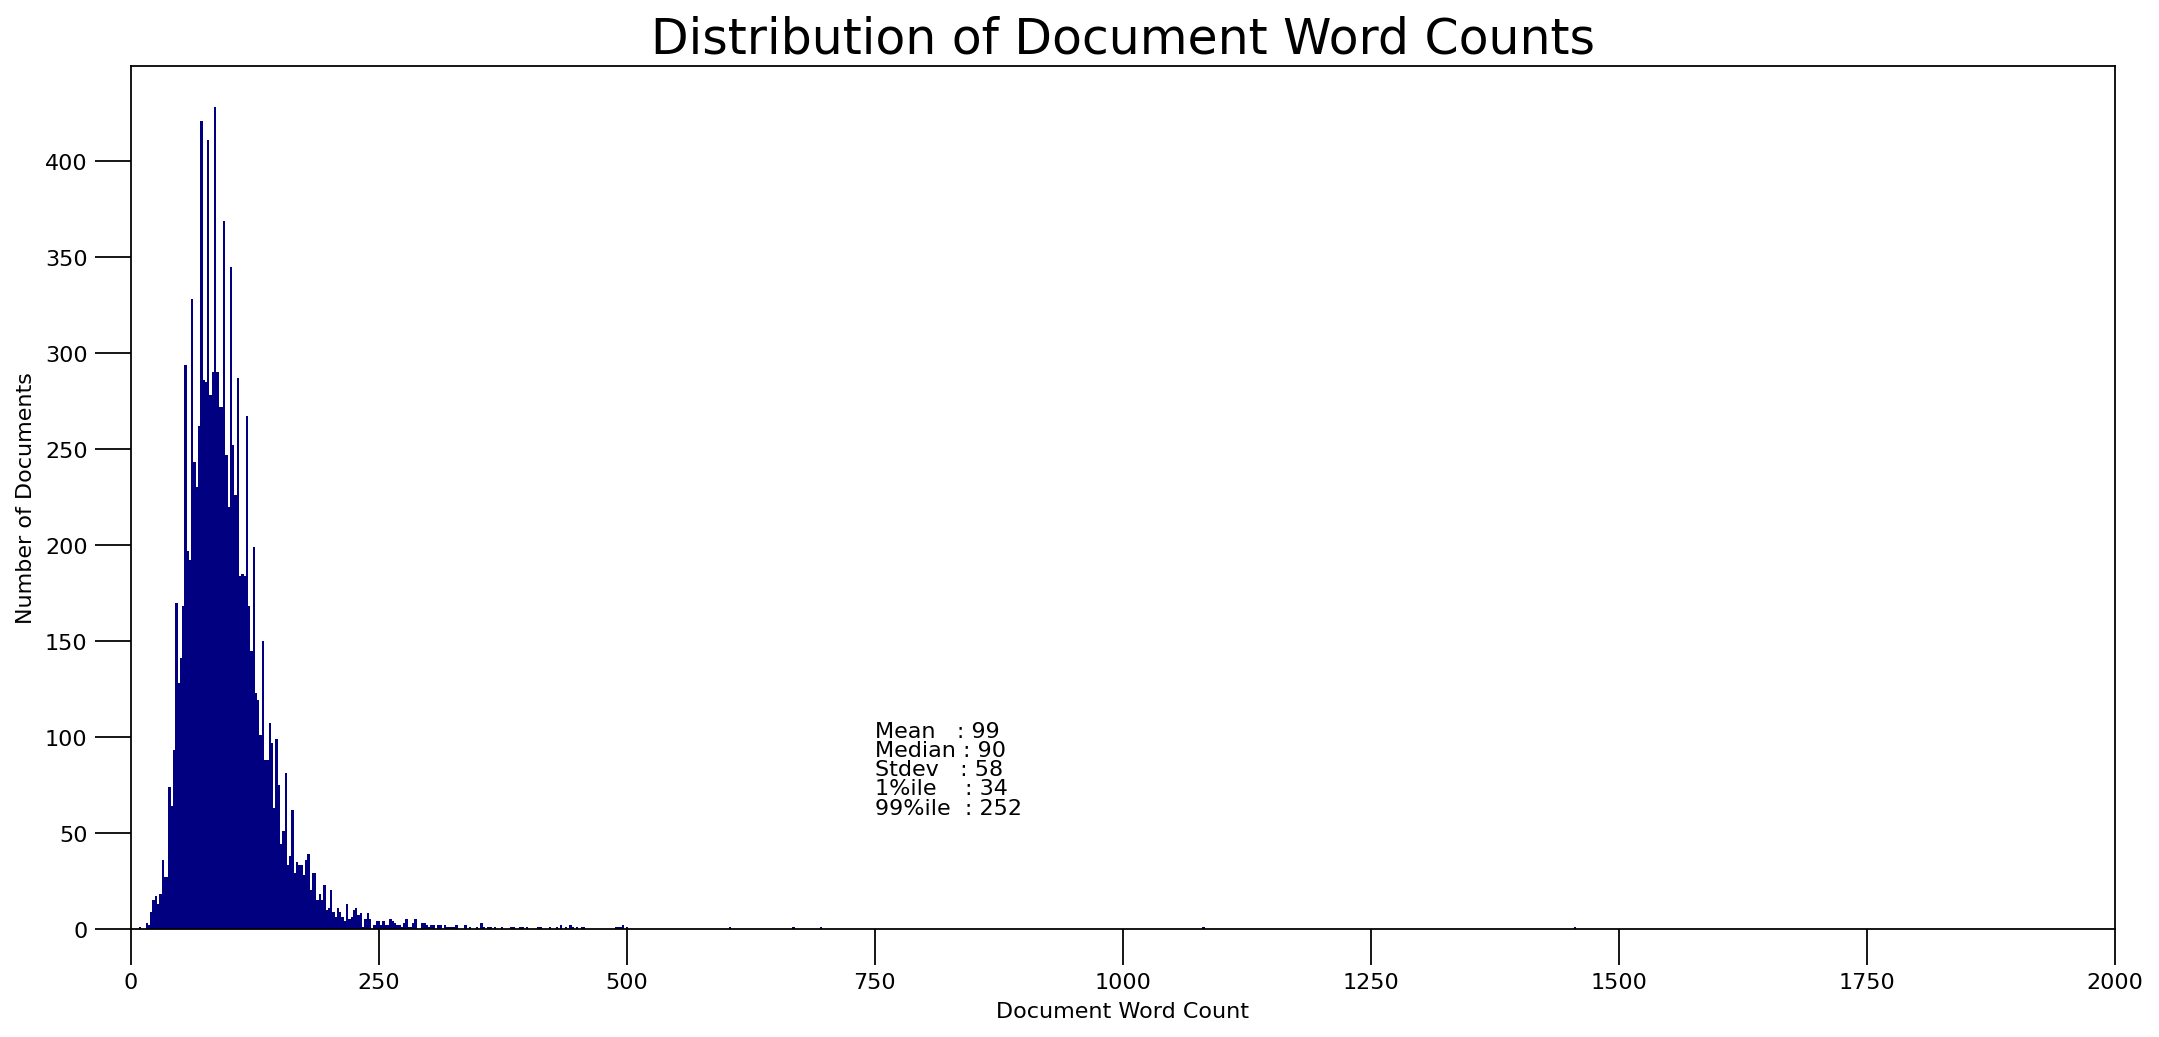

In [42]:
doc_lens = [len(d) for d in all_doc_topics.text]
# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 2000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,2000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

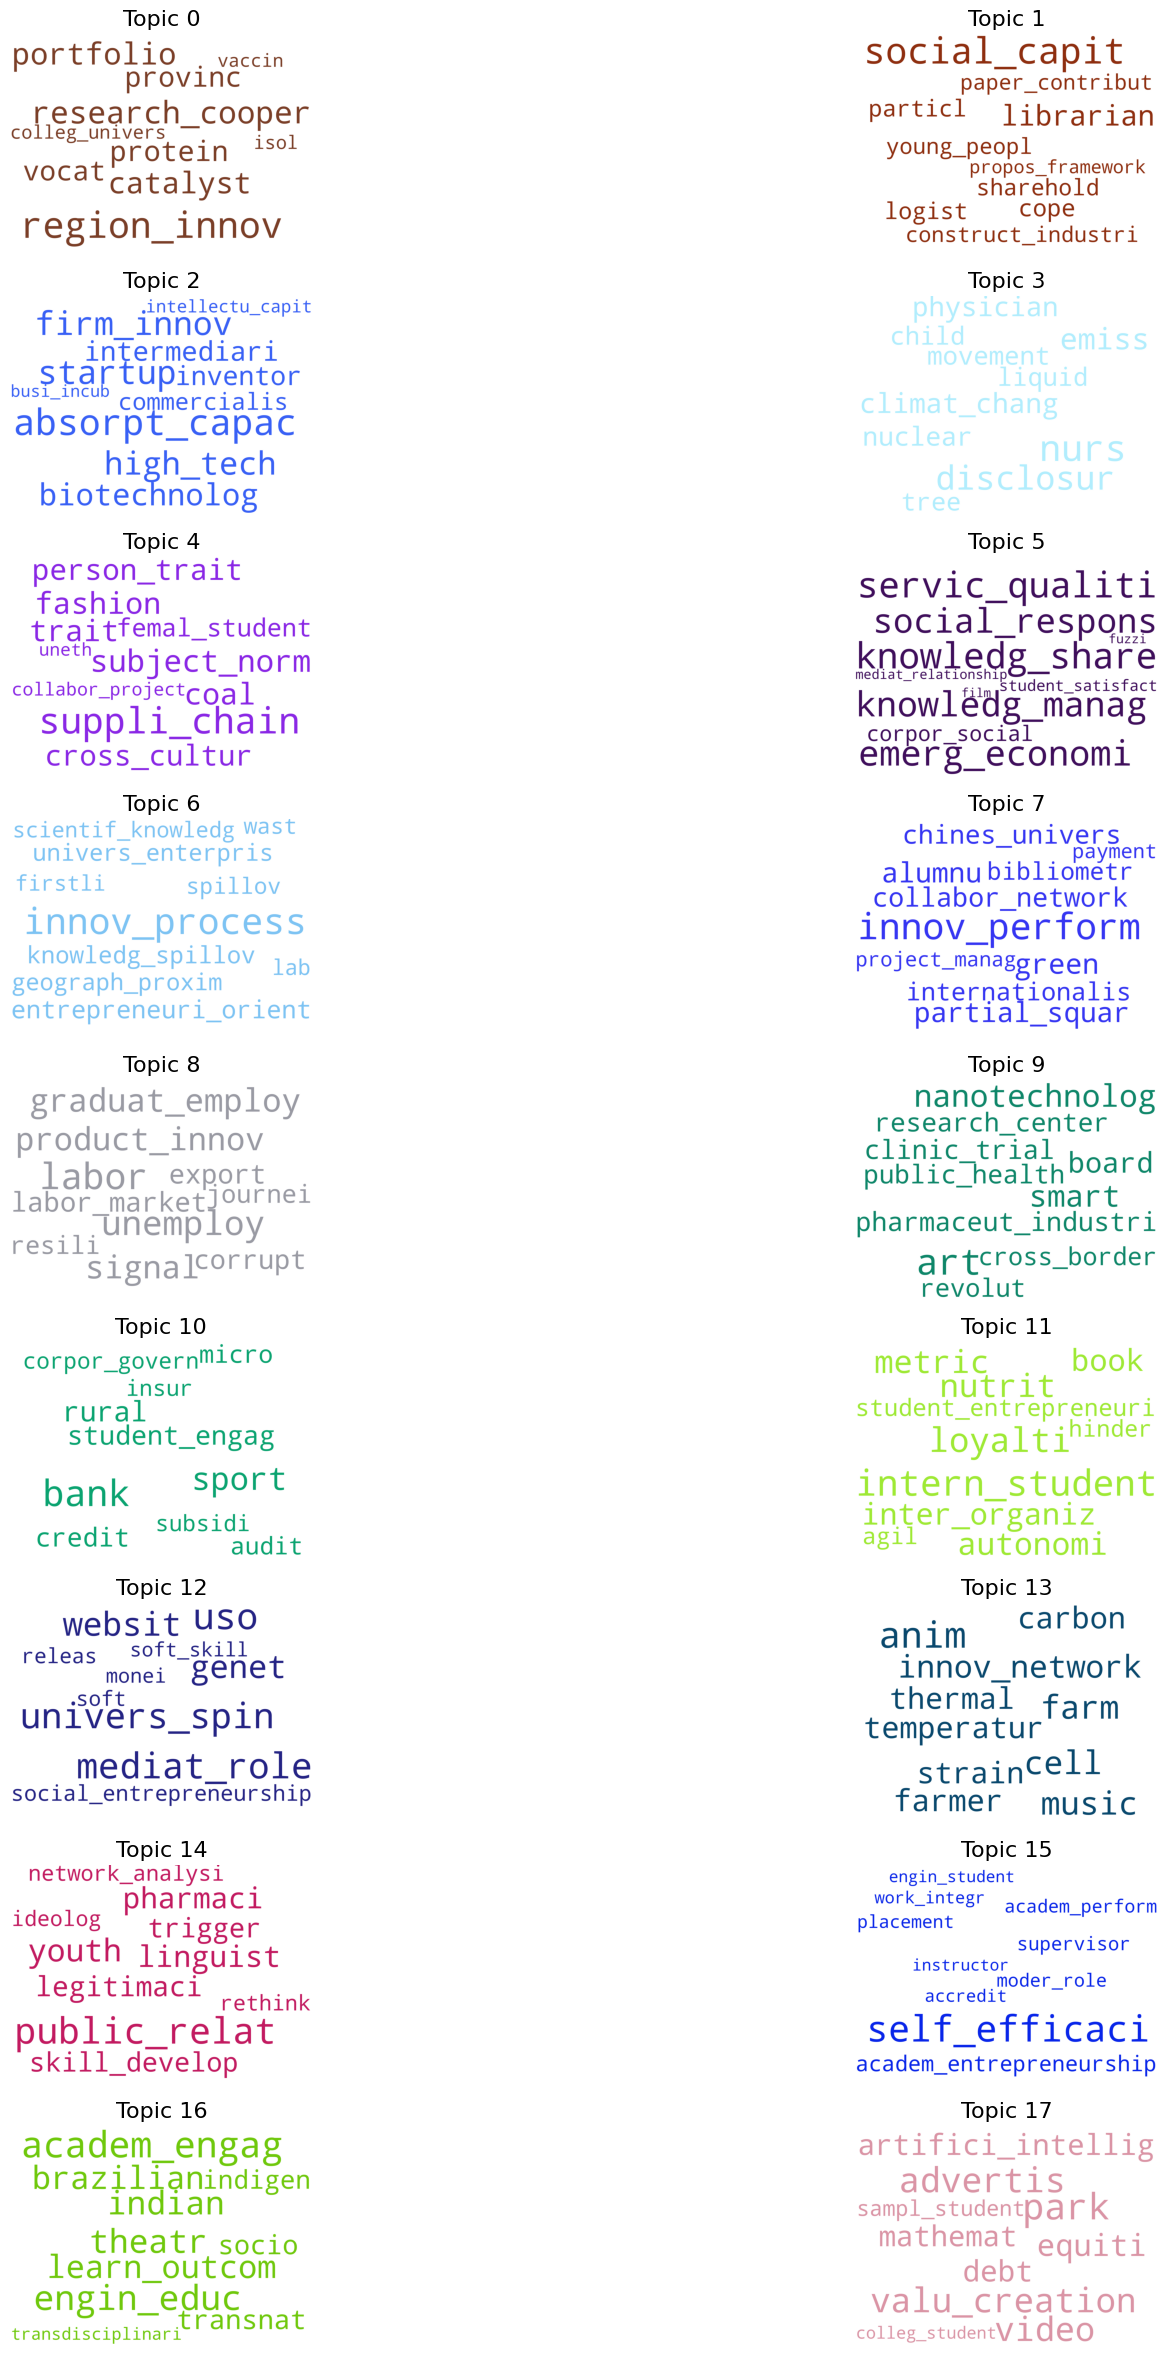

In [27]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

no_of_colors = model.num_topics
cols=["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
       for j in range(no_of_colors)]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(9, 2, figsize=(20,30), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(model.show_topic(i))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.axis('off')
plt.show()

In [43]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, train_corpus, dictionary=train_dictionary)
pyLDAvis.save_html(vis, 'intertopic_distance_map.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
15    -0.041204  0.024448       1        1  7.969837
12    -0.024004  0.127650       2        1  7.447947
14    -0.065730 -0.041734       3        1  6.436083
2     -0.100795  0.015044       4        1  6.036117
0     -0.079734 -0.044601       5        1  5.725031
1     -0.001803  0.041035       6        1  5.649448
6     -0.119099  0.074878       7        1  5.642452
9      0.094396  0.105293       8        1  5.457729
3      0.176030  0.046263       9        1  5.335687
7     -0.205453 -0.013022      10        1  5.310102
13     0.061452 -0.022014      11        1  5.232393
8      0.044829  0.131583      12        1  5.224346
4     -0.172306 -0.181752      13        1  5.069262
16     0.064886 -0.008668      14        1  5.039866
17    -0.060139 -0.004579      15        1  5.027475
11     0.102156 -0.235524      16        1  4.686907
10     0.106708  0.184345      17        1  4.557985
5      0.219812 -0.198646      18        1  4.151332, topic_info=                Term       Freq      Total Category  logprob  loglift
1747            bank  51.000000  51.000000  Default  30.0000  30.0000
2504           sport  39.000000  39.000000  Default  29.0000  29.0000
2997   innov_perform  40.000000  40.000000  Default  28.0000  28.0000
2812    social_capit  40.000000  40.000000  Default  27.0000  27.0000
2808  knowledg_share  34.000000  34.000000  Default  26.0000  26.0000
...              ...        ...        ...      ...      ...      ...
1584         theoriz  12.853344  15.182403  Topic18  -4.7907   3.0152
101          founder  14.733375  20.584520  Topic18  -4.6542   2.8473
406         canadian  12.155129  17.411904  Topic18  -4.8465   2.8223
1005           check  11.411533  15.609917  Topic18  -4.9097   2.8685
525           retent  11.272021  21.986559  Topic18  -4.9220   2.5136

[880 rows x 6 columns], token_table=      Topic      Freq                 Term
term                                      
1004      5  1.023612              absorpt
2380      4  0.998449        absorpt_capac
2739      1  0.965816        academ_achiev
1909     14  0.982396         academ_engag
3183      1  0.971636  academ_entrepreneur
...     ...       ...                  ...
2962      2  0.233098          young_peopl
2962      6  0.757567          young_peopl
1831      2  0.048197                youth
1831      3  0.819341                youth
1831     15  0.096393                youth

[1362 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 13, 15, 3, 1, 2, 7, 10, 4, 8, 14, 9, 5, 17, 18, 12, 11, 6])

# Dominant Topic of each document and published year

In [31]:
documents_year = pd.DataFrame(lemmatized_texts, columns=['lemmatized_texts'])
documents_year['publish_year'] = df.publish_year
doc_topics = []
for i in range(len(documents_year)):
    doc = documents_year.lemmatized_texts[i]
    doc_tokens = document_preprocessing([doc])
    doc_tokens = make_bigrams(doc_tokens)
    doc_corpus = train_dictionary.doc2bow(doc_tokens[0])
    tfidf = gensim.models.TfidfModel(corpus=doc_corpus, dictionary=train_dictionary)
    doc_corpus_tfidf = tfidf[doc_corpus]
    if model.per_word_topics:
        theta = dict(model[doc_corpus_tfidf][0])
    else:
        theta = dict(model[doc_corpus_tfidf])
    topic = max(theta, key=theta.get)
    doc_topics.append(topic)

documents_year["Dominant_topic"] = doc_topics
documents_year.to_csv("documents_year_topic.csv")
documents_year

lemmatized_texts  publish_year  \
0      progress report online centralize c-14 datum m...          1989   
1      application ams collaborative program underway...          1990   
2      technology unique partnership industry state g...          1990   
3      present future use semiochemical compound affe...          1990   
4      industry cooperation penn study now year old s...          1990   
...                                                  ...           ...   
11348  international orientation academic entrepreneu...          2022   
11349  impact human social psychological capital acad...          2022   
11350  friend foe effect harmonious obsessive passion...          2022   
11351  exergy study amine regeneration unit diethanol...          2022   
11352  innovation park seek become global centre inno...          2022   

       Dominant_topic  
0                  14  
1                   6  
2                  12  
3                   3  
4                   0  
...               ...  
11348              12  
11349              15  
11350              17  
11351               7  
11352               4  

[11353 rows x 3 columns]

# Document frequency for each topic over years

In [185]:
years = np.arange(min(df.publish_year), max(df.publish_year))
topic_year_list = []
for year in years:
    filter_docs = documents_year.loc[documents_year["publish_year"] == year]["Dominant_topic"]
    year_dict = dict.fromkeys(np.arange(0, model.num_topics, 1), 0)
    values, count = np.unique(np.array(filter_docs).tolist(), return_counts=True)
    year_dict.update(dict(zip(values,count)))
    topic_year_list.append(year_dict)
topic_year_df = pd.DataFrame(topic_year_list, index=years)
columns = ["topic"+str(i+1) for i in range(model.num_topics)]
topic_year_df.columns = columns
topic_year_df.to_csv("topic_year_df.csv")
topic_year_df

topic1  topic2  topic3  topic4  topic5  topic6  topic7  topic8  topic9  \
1989       0       0       0       0       0       0       0       0       0   
1990       1       0       0       1       0       1       1       0       0   
1991       2       1       0       1       3       0       0       2       0   
1992       3       3       1       1       0       2       0       3       0   
1993       3       2       2       2       2       1       0       1       3   
1994       3       3       1       3       5       1       4       0       2   
1995       1       4       5       4       1       2       2       7       4   
1996       3       4       5       6       2       1       4       2       4   
1997       4       3       4      13       2       2       3       1       2   
1998       5       1       3       6       5       2       1       4       1   
1999       3       5       4      12       3       3       3       4       1   
2000       5       5       4       8       5       2       2       1       1   
2001       4       3       6      11       2       0       0       4       4   
2002       8       6       3       4       5       5      11       5       4   
2003       5       4       5      10       3       4       4       7       6   
2004       5       4       6       5       3       1       6       2       4   
2005      11       6      10      18       7       5      12       5      11   
2006      12      16       7      16       7       2       8       8      11   
2007      19      12      18       9      15       3      11      11       9   
2008      17      11      10      20      16       7      15      11      16   
2009      24      13      12      25      16       4       7      13      18   
2010      18      16      23      27      19      11      19      16      27   
2011      33      17      17      31      20       7      20      21      17   
2012      22      24      23      29      29       8      23      24      16   
2013      29      22      27      38      30      11      25      25      24   
2014      23      21      24      30      22       8      19      22      27   
2015      21      19      27      36      28      16      30      18      28   
2016      39      35      39      37      39       8      27      22      29   
2017      38      34      33      38      33      14      49      27      36   
2018      38      41      30      57      34      12      34      36      38   
2019      48      42      37      51      38      21      42      41      36   
2020      50      30      26      66      31      15      47      42      35   
2021      54      47      59      69      49      23      56      53      37   

      topic10  topic11  topic12  topic13  topic14  topic15  topic16  topic17  \
1989        0        0        0        0        0        1        0        0   
1990        0        0        0        1        1        0        1        0   
1991        2        2        1        1        3        2        1        3   
1992        6        1        1        1        1        4        2        1   
1993        5        2        0        2        2        2        6        1   
1994        4        4        4        3        6        4        5        0   
1995        5        2        3        8        4        3        1        2   
1996        5        2        2        8        6        7        4        3   
1997        8        4        2       15        1        8        8        3   
1998        6        2        4       12        7        7        5        7   
1999        6        2        4       18       10        1        2        7   
2000        8       12        8       18       10        8        4        5   
2001        4        4        6       23        9        8        5        2   
2002        3        4        6       11       10        5        2        6   
2003        7        8        6       12       13        8        7        5   
2004 

# Term frequency of top 50 terms of each topic

In [307]:
dictionary = corpora.Dictionary(tokens)
dictionary.filter_extremes(no_below=20, no_above=0.01)
corpus = [dictionary.doc2bow(text) for text in tokens]
dense_corpus = gensim.matutils.corpus2dense(corpus=corpus, num_docs=len(corpus), num_terms=len(dictionary))
vocab = list(dict(dictionary).values())
dense_corpus_df = pd.DataFrame(dense_corpus)
term_freq = pd.DataFrame(np.sum(dense_corpus_df, axis=1), columns=["freq"])
term_freq["term"] = vocab

all_topic_freq = pd.DataFrame()
for n in range(model.num_topics):
    top_terms_per_topic = list(dict(model.show_topic(n, 50)).keys())
    frequency = []
    for i in range(len(top_terms_per_topic)):
        freq = term_freq.loc[term_freq["term"] == top_terms_per_topic[i]]
        frequency.append(np.array(freq.freq)[0])
    topic_freq = pd.DataFrame(top_terms_per_topic, columns=["term"])
    topic_freq["frequency"] = frequency
    topic_freq.sort_values(by="frequency")
    all_topic_freq = pd.concat([all_topic_freq,topic_freq], axis=1)
all_topic_freq.to_csv("all_topic_top_term_freq.csv")

In [306]:
all_topic_freq

term  frequency                 term  frequency  \
0        region_innov      206.0         social_capit      245.0   
1     research_cooper      110.0            librarian      135.0   
2           portfolio      192.0                 cope      120.0   
3            catalyst      118.0              particl      149.0   
4             protein      188.0               logist      123.0   
5             provinc      138.0            sharehold      115.0   
6               vocat      175.0          young_peopl      100.0   
7      colleg_univers       92.0   construct_industri      146.0   
8                isol      154.0      paper_contribut      107.0   
9              vaccin      101.0     propos_framework       57.0   
10              remot      144.0         busi_process      109.0   
11   knowledg_exchang      117.0       privat_univers      102.0   
12          diversifi       69.0               machin      191.0   
13            conting      122.0           risk_manag       71.0   
14  curriculum_design       63.0               tunnel       80.0   
15              blend       87.0               procur       73.0   
16           synchron       62.0             recoveri      109.0   
17               gene      116.0        knowledg_flow       92.0   
18           investor      157.0                 ship       58.0   
19     basic_research      110.0             workload       66.0   
20           outsourc       77.0       research_topic       52.0   
21      boundari_span       55.0              classif      153.0   
22    financi_perform       63.0    dissemin_knowledg       31.0   
23              stock      162.0         introduc_new       45.0   
24      food_industri       71.0        primari_datum       58.0   
25       invert_shape       45.0           model_base      102.0   
26      public_polici      102.0              appoint       73.0   
27          base_find       51.0        social_cognit       40.0   
28            absorpt       68.0     provid_framework       33.0   
29        busi_sector       82.0             mismatch       88.0   
30          postgradu      160.0        intern_market       39.0   
31   knowledg_product      129.0      market_strategi       43.0   
32     find_highlight       46.0                 mine      219.0   
33         vocat_educ       64.0           self_regul       37.0   
34         government      124.0             corrobor       32.0   
35     integr_sustain       49.0                dutch       74.0   
36             listen       53.0       studi_identifi       83.0   
37    organiz_perform       47.0          earli_stage      124.0   
38                pro       96.0       compet_develop       54.0   
39       emerg_market       46.0              keyword       39.0   
40         busi_manag      137.0                media       44.0   
41   knowledg_economi       52.0      direct_indirect       53.0   
42    develop_economi       63.0              correct      113.0   
43      busi_strategi       52.0                 miss       77.0   
44      engag_student       54.0       busi_administr       50.0   
45      approach_case       50.0                 venu       49.0   
46     increas_attent       43.0    develop_implement       96.0   
47              globe       48.0     differ_stakehold       53.0   
48        interdepend       87.0  significantli_posit       47.0   
49   knowledg_network       39.0               oxygen      102.0   

                  term  frequency              term  frequency  \
0        absorpt_capac      245.0              nurs      279.0   
1              startup      151.0         disclosur      248.0   
2           firm_innov      145.0             emiss      200.0   
3            high_tech      193.0      climat_chang      129.0   
4         biotechnolog      210.0         physician      278.0   
5         intermediari      164.0           nuclear      139.0   
6             inventor      162.0          movement      160.0   
7         commercial

# Compute theta

In [32]:
def compute_theta_year(model):
    years = np.arange(min(df.publish_year), max(df.publish_year))
    theta_year = []
    for year in years:
        filtered_docs = documents_year.loc[documents_year['publish_year']==year]['lemmatized_texts']
        filtered_docs_tokens = document_preprocessing(filtered_docs.values)
        filtered_docs_tokens = make_bigrams(filtered_docs_tokens)
        filtered_corpus = [train_dictionary.doc2bow(text) for text in filtered_docs_tokens]
        tfidf = gensim.models.TfidfModel(corpus=filtered_corpus, dictionary=train_dictionary)
        corpus_tfidf_filtered = tfidf[filtered_corpus]
        num_filtered_doc = len(corpus_tfidf_filtered)
        theta_dict = dict.fromkeys(np.arange(0, model.num_topics, 1), 0)
        for i in range(num_filtered_doc):
            if model.per_word_topics:
                theta = dict(model[corpus_tfidf_filtered[i]][0])
            else:
                theta = dict(model[corpus_tfidf_filtered[i]])
            theta_dict = {key: theta_dict.get(key, 0) + theta.get(key, 0)
                         for key in set(theta_dict) | set(theta)}
        theta_dict = {key: theta_dict.get(key, 0)/num_filtered_doc for key in set(theta_dict)}
        theta_year.append(theta_dict)
    theta_year = pd.DataFrame(theta_year, index=years.tolist()).transpose()
    return theta_year

theta_year = compute_theta_year(model)
theta_year.to_csv("theta_year.csv")
theta_year

1989      1990      1991      1992      1993      1994      1995  \
0   0.021411  0.043898  0.044494  0.036738  0.060938  0.049875  0.042325   
1   0.021412  0.047282  0.045513  0.075455  0.045554  0.054650  0.050519   
2   0.021416  0.057824  0.027975  0.056758  0.057185  0.036389  0.051316   
3   0.021422  0.067471  0.066213  0.063987  0.066824  0.063799  0.059997   
4   0.112918  0.060926  0.075600  0.031917  0.049705  0.069049  0.051539   
5   0.021411  0.056737  0.034206  0.054759  0.031299  0.036122  0.050430   
6   0.021412  0.062465  0.029726  0.039352  0.039896  0.058080  0.047545   
7   0.021416  0.027914  0.067501  0.063475  0.034630  0.033660  0.070065   
8   0.021411  0.037289  0.043495  0.036513  0.066520  0.048789  0.062139   
9   0.021413  0.029825  0.071192  0.088611  0.075746  0.070292  0.067015   
10  0.021412  0.085762  0.054215  0.046518  0.048156  0.061186  0.044960   
11  0.226363  0.027912  0.059715  0.048149  0.039153  0.053243  0.053981   
12  0.021413  0.086820  0.061887  0.053401  0.052651  0.057834  0.087711   
13  0.021421  0.092293  0.089373  0.059334  0.089070  0.077691  0.083774   
14  0.339510  0.027911  0.067923  0.079637  0.051453  0.074725  0.045959   
15  0.021412  0.103299  0.049563  0.055146  0.084590  0.066628  0.040501   
16  0.021416  0.056458  0.062569  0.045858  0.057146  0.044182  0.046989   
17  0.021411  0.027915  0.048838  0.064393  0.049484  0.043805  0.043234   

        1996      1997      1998  ...      2012      2013      2014      2015  \
0   0.043338  0.034973  0.041661  ...  0.047254  0.049504  0.051645  0.050086   
1   0.050957  0.049282  0.038546  ...  0.051960  0.049783  0.051878  0.051768   
2   0.056363  0.043059  0.043770  ...  0.050624  0.055827  0.051714  0.051031   
3   0.080227  0.094089  0.063886  ...  0.060055  0.064662  0.058801  0.059118   
4   0.045819  0.048021  0.054333  ...  0.058921  0.052830  0.051242  0.054782   
5   0.037202  0.045189  0.038168  ...  0.042817  0.040331  0.041129  0.041086   
6   0.058642  0.045075  0.032731  ...  0.052217  0.052940  0.045557  0.050615   
7   0.047496  0.047155  0.050208  ...  0.053819  0.052207  0.053315  0.050495   
8   0.045999  0.039141  0.034150  ...  0.047230  0.048302  0.052903  0.050862   
9   0.058713  0.067762  0.077011  ...  0.066539  0.062129  0.060962  0.061145   
10  0.042098  0.055207  0.048894  ...  0.054820  0.055030  0.055754  0.056791   
11  0.042238  0.047297  0.057467  ...  0.060731  0.050839  0.052322  0.048897   
12  0.083748  0.101217  0.108186  ...  0.068291  0.071935  0.072585  0.075932   
13  0.077283  0.054751  0.067189  ...  0.057179  0.062152  0.061001  0.060039   
14  0.069100  0.065154  0.054977  ...  0.062958  0.065704  0.064074  0.061711   
15  0.067917  0.068307  0.054519  ...  0.067727  0.062617  0.069532  0.071741   
16  0.054026  0.044590  0.068121  ...  0.054321  0.055154  0.054392  0.053167   
17  0.038835  0.049734  0.066184  ...  0.042538  0.048054  0.051195  0.050734   

        2016      2017      2018      2019      2020      2021  
0   0.055675  0.051137  0.049923  0.049239  0.052101  0.050648  
1   0.055483  0.053045  0.055110  0.052842  0.050520  0.055342  
2   0.052780  0.048180  0.049360  0.055963  0.047227  0.056254  
3   0.057337  0.060768  0.063920  0.056255  0.061837  0.056940  
4   0.059531  0.052623  0.051609  0.050305  0.048828  0.053139  
5   0.036547  0.039012  0.041904  0.041823  0.044709  0.046923  
6   0.049769  0.053611  0.049391  0.051718  0.053770  0.049833  
7   0.046952  0.051108  0.051370  0.055099  0.052627  0.055902  
8   0.050224  0.049001  0.050915  0.050977  0.048335  0.047612  
9   0.060029  0.060686  0.059110  0.056558  0.058449  0.055980  
10  0.062387  0.056424  0.057960  0.052653  0.056202  0.055932  
11  0.050627  0.047406  0.056000  0.052320  0.052903  0.051583  
12  0.071238  0.078799  0.073951  0.077565  0.074146  0.072390  
13  0.057440  0.059985  0.054380  0.055840  0.061629  0.061214  
14  0.061801  0.065957  0.061517  0.059774  0.06

# Topic Trend Analysis by Year: recent 1991–2021
# Split to 3 part

In [368]:
from scipy import stats
def reg_predict(X, slop, intercept):
    y_pred = intercept + slop * X
    return y_pred

def parser(cols):
    slopes = cols["Coefficient"]
    ps = cols["p_value"]
    cat = []
    for i in range(len(slopes)):
        slope = slopes[i]
        p = ps[i]
        if slope > 0:
            if p<=0.05:
                cat.append("Hot")
            else:
                cat.append("Warm")
        else:
            if p<=0.05:
                cat.append("Cold")
            else:
                cat.append("Cool")
    return cat

X1 = np.arange(1991, 2002)
X2 = np.arange(2001, 2012)
X3 = np.arange(2011, 2022)
X = [X1, X2, X3]
coefficients = []

slopes = []
intercepts = []
p_vals = []
for i in range(model.num_topics):
    coefficient = []
    p_val = []
    interception = []
    for j in range(len(X)):
        x = X[j]
        if j == 0:
            y = theta_year.iloc[i][2:13]
        elif j == 1:
            y = theta_year.iloc[i][12:23]
        else:
            y = theta_year.iloc[i][22:33]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        coefficient.append(slope)
        interception.append(intercept)
        p_val.append(p_value)
    slopes.append(coefficient)
    intercepts.append(interception)
    p_vals.append(p_val)

In [374]:
topic_category_three = pd.DataFrame()
topic_category_three["Topic"] = ['T'+ str(i+1) for i in range(model.num_topics)]
topic_category_three["Coefficient"] = slopes
topic_category_three["p_value"] = p_vals
topic_category_three["Topic_Category"] = topic_category_three[["Coefficient","p_value"]].apply(parser, axis=1)
topic_category_three.to_csv("topic_category_three.csv")
topic_category_three

Topic                                        Coefficient  \
0     T1    [0.0005541503802605846, -0.0004045381900815658]   
1     T2   [-0.00039931361584376877, 8.974880676105473e-05]   
2     T3      [0.00028230340915395597, 0.00029936503464902]   
3     T4   [-5.931411090638204e-05, -0.0005392794972704481]   
4     T5  [-0.0010226141035069604, -0.00016338673556926298]   
5     T6   [-0.00018978712256572137, 0.0004910763398691499]   
6     T7    [0.0005305548661245954, 0.00014991464422858504]   
7     T8  [-0.00043633351630092173, 0.00039336670626436814]   
8     T9    [4.892942420105036e-05, -7.656067494265106e-05]   
9    T10   [-0.0008318512020205577, -0.0002218590691838007]   
10   T11     [5.164108167093814e-05, 0.0002399118306796923]   
11   T12     [0.0003847893104168607, 0.0001903313058850885]   
12   T13     [0.0021946525252303202, -0.000194740304203524]   
13   T14  [-0.00033218064145028574, -0.0006806970532088897]   
14   T15   [-0.000515037202483755, -0.00018358045493008452]   
15   T16    [-0.00027719492020640915, 0.000774804970217145]   
16   T17   [0.00043176962052290593, -0.0001984126211152759]   
17   T18    [-0.0004151645222628055, 3.453495677179775e-05]   

                                        p_value Topic_Category  
0    [0.16488726257530842, 0.03323903322829851]   [Warm, Cold]  
1     [0.41048302405366355, 0.5516303627898151]   [Cool, Warm]  
2     [0.5605148674712367, 0.31833879566365747]   [Warm, Warm]  
3   [0.9243950796118681, 0.0019814239408260438]   [Cool, Cold]  
4      [0.0716435323283887, 0.5169650588151771]   [Cool, Cool]  
5   [0.6190040138628657, 0.0036120936346478406]    [Cool, Hot]  
6      [0.4000343100003678, 0.5264455073989855]   [Warm, Warm]  
7    [0.4565424809975649, 0.022515719257994393]    [Cool, Hot]  
8      [0.9304579225582919, 0.6562370316669832]   [Warm, Cool]  
9     [0.07343640379686908, 0.5119009752789394]   [Cool, Cool]  
10    [0.8974403670179728, 0.11016488259558782]   [Warm, Warm]  
11    [0.26233176786267665, 0.4002105835226154]   [Warm, Warm]  
12    [0.04896105308811251, 0.3949115893387324]    [Hot, Cool]  
13  [0.5442525618058023, 0.0010302674558608012]   [Cool, Cold]  
14    [0.4107089974684951, 0.24127318963702413]   [Cool, Cool]  
15   [0.6682611889184891, 0.001171880980420393]    [Cool, Hot]  
16    [0.35090306794866044, 0.3345336092693978]   [Warm, Cool]  
17      [0.418569083055631, 0.8222722568657087]   [Cool, Warm]

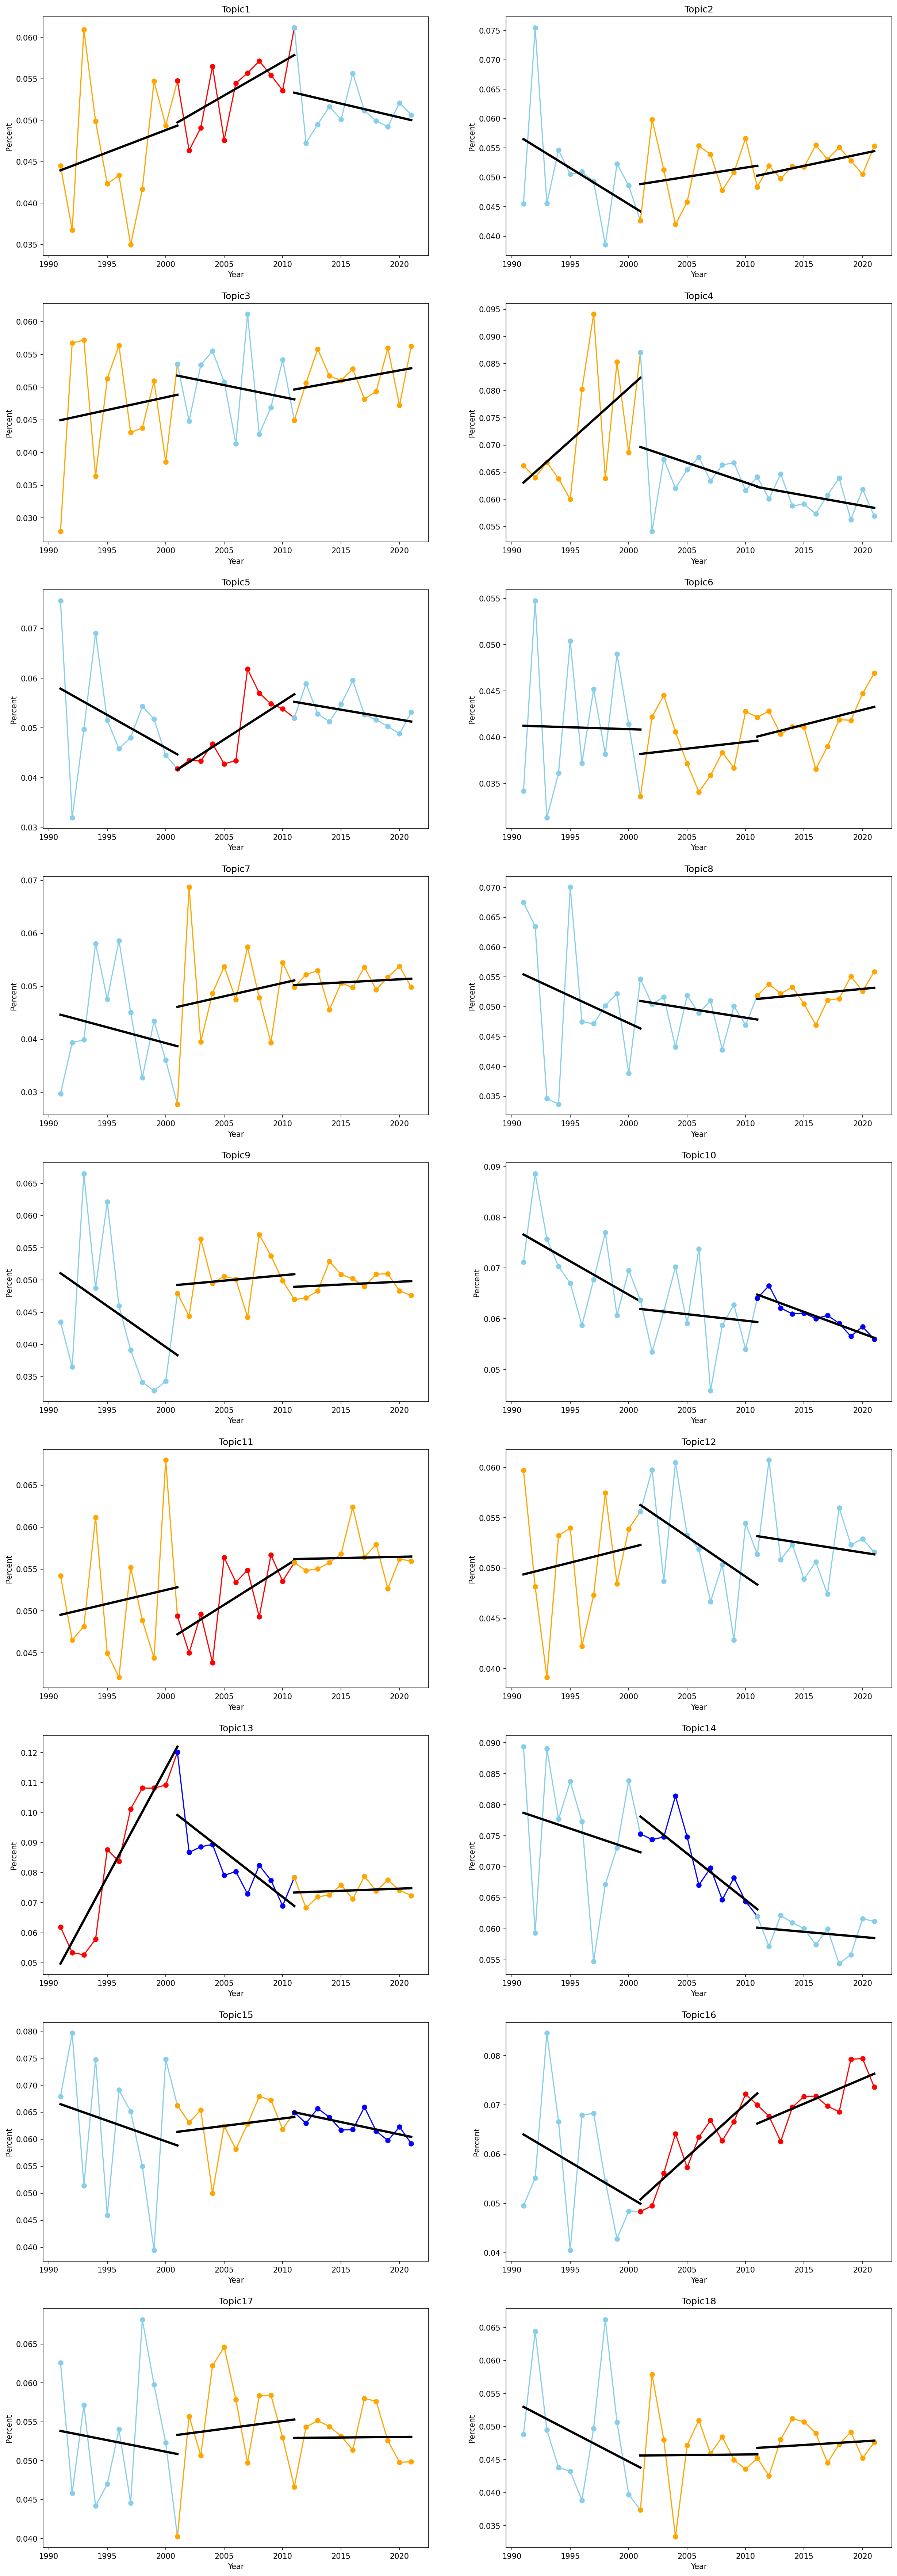

In [370]:
plt.figure(figsize=(20,60),dpi=150)
col = "black"
for i in range(model.num_topics):
    for j in range(len(X)):
        x = X[j]
        if topic_category_three.Topic_Category[i][j] == "Hot":
            col = "red"
        elif topic_category_three.Topic_Category[i][j] == "Warm":
            col = "orange"
        elif topic_category_three.Topic_Category[i][j] == "Cold":
            col = "blue"
        elif topic_category_three.Topic_Category[i][j] == "Cool":
            col = "skyblue"

        if j == 0:
            y = theta_year.iloc[i][2:13]
        elif j == 1:
            y = theta_year.iloc[i][12:23]
        else:
            y = theta_year.iloc[i][22:33]

        k = i + 1
        plt.subplot(9, 2, k)
        plt.plot(y,'o-',color=col)
        plt.plot(x, reg_predict(x, slopes[i][j], intercepts[i][j]), linewidth=3, color="black")
        plt.xlabel("Year")
        plt.ylabel("Percent")
        plt.title('Topic'+str(k))

    fig.subplots_adjust(top=2)

# Split to 2 part

In [371]:
from scipy import stats
def reg_predict(X, slop, intercept):
    y_pred = intercept + slop * X
    return y_pred

def parser(cols):
    slopes = cols["Coefficient"]
    ps = cols["p_value"]
    cat = []
    for i in range(len(slopes)):
        slope = slopes[i]
        p = ps[i]
        if slope > 0:
            if p<=0.05:
                cat.append("Hot")
            else:
                cat.append("Warm")
        else:
            if p<=0.05:
                cat.append("Cold")
            else:
                cat.append("Cool")
    return cat

X1 = np.arange(1991, 2007)
X2 = np.arange(2006, 2022)
X = [X1, X2]
coefficients = []

slopes = []
intercepts = []
p_vals = []
for i in range(model.num_topics):
    coefficient = []
    p_val = []
    interception = []
    for j in range(2):
        x = X[j]
        if j == 0:
            y = theta_year.iloc[i][2:18]
        else:
            y = theta_year.iloc[i][17:33]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        coefficient.append(slope)
        interception.append(intercept)
        p_val.append(p_value)
    slopes.append(coefficient)
    intercepts.append(interception)
    p_vals.append(p_val)

In [372]:
topic_category_two = pd.DataFrame()
topic_category_two["Topic"] = ['T'+ str(i+1) for i in range(model.num_topics)]
topic_category_two["Coefficient"] = slopes
topic_category_two["p_value"] = p_vals
topic_category_two["Topic_Category"] = topic_category_two[["Coefficient","p_value"]].apply(parser, axis=1)
topic_category_two.to_csv("topic_category_two.csv")
topic_category_two

Topic                                        Coefficient  \
0     T1    [0.0005541503802605846, -0.0004045381900815658]   
1     T2   [-0.00039931361584376877, 8.974880676105473e-05]   
2     T3      [0.00028230340915395597, 0.00029936503464902]   
3     T4   [-5.931411090638204e-05, -0.0005392794972704481]   
4     T5  [-0.0010226141035069604, -0.00016338673556926298]   
5     T6   [-0.00018978712256572137, 0.0004910763398691499]   
6     T7    [0.0005305548661245954, 0.00014991464422858504]   
7     T8  [-0.00043633351630092173, 0.00039336670626436814]   
8     T9    [4.892942420105036e-05, -7.656067494265106e-05]   
9    T10   [-0.0008318512020205577, -0.0002218590691838007]   
10   T11     [5.164108167093814e-05, 0.0002399118306796923]   
11   T12     [0.0003847893104168607, 0.0001903313058850885]   
12   T13     [0.0021946525252303202, -0.000194740304203524]   
13   T14  [-0.00033218064145028574, -0.0006806970532088897]   
14   T15   [-0.000515037202483755, -0.00018358045493008452]   
15   T16    [-0.00027719492020640915, 0.000774804970217145]   
16   T17   [0.00043176962052290593, -0.0001984126211152759]   
17   T18    [-0.0004151645222628055, 3.453495677179775e-05]   

                                        p_value Topic_Category  
0    [0.16488726257530842, 0.03323903322829851]   [Warm, Cold]  
1     [0.41048302405366355, 0.5516303627898151]   [Cool, Warm]  
2     [0.5605148674712367, 0.31833879566365747]   [Warm, Warm]  
3   [0.9243950796118681, 0.0019814239408260438]   [Cool, Cold]  
4      [0.0716435323283887, 0.5169650588151771]   [Cool, Cool]  
5   [0.6190040138628657, 0.0036120936346478406]    [Cool, Hot]  
6      [0.4000343100003678, 0.5264455073989855]   [Warm, Warm]  
7    [0.4565424809975649, 0.022515719257994393]    [Cool, Hot]  
8      [0.9304579225582919, 0.6562370316669832]   [Warm, Cool]  
9     [0.07343640379686908, 0.5119009752789394]   [Cool, Cool]  
10    [0.8974403670179728, 0.11016488259558782]   [Warm, Warm]  
11    [0.26233176786267665, 0.4002105835226154]   [Warm, Warm]  
12    [0.04896105308811251, 0.3949115893387324]    [Hot, Cool]  
13  [0.5442525618058023, 0.0010302674558608012]   [Cool, Cold]  
14    [0.4107089974684951, 0.24127318963702413]   [Cool, Cool]  
15   [0.6682611889184891, 0.001171880980420393]    [Cool, Hot]  
16    [0.35090306794866044, 0.3345336092693978]   [Warm, Cool]  
17      [0.418569083055631, 0.8222722568657087]   [Cool, Warm]

In [373]:
plt.figure(figsize=(20,60),dpi=150)
col = "black"
for i in range(model.num_topics):
    for j in range(len(X)):
        x = X[j]
        if topic_category_two.Topic_Category[i][j] == "Hot":
            col = "red"
        elif topic_category_two.Topic_Category[i][j] == "Warm":
            col = "orange"
        elif topic_category_two.Topic_Category[i][j] == "Cold":
            col = "blue"
        elif topic_category_two.Topic_Category[i][j] == "Cool":
            col = "skyblue"

        if j == 0:
            y = theta_year.iloc[i][2:18]
        else:
            y = theta_year.iloc[i][17:33]

        k = i + 1
        plt.subplot(9, 2, k)
        plt.plot(y,'o-',color=col)
        plt.plot(x, reg_predict(x, slopes[i][j], intercepts[i][j]), linewidth=3, color="black")
        plt.xlabel("Year")
        plt.ylabel("Percent")
        plt.title('Topic'+str(k))

    fig.subplots_adjust(top=2)

In [61]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import seaborn as sns

# Get topic weights
topic_weights = []
for i, row_list in enumerate(model[train_corpus]):
    topic_weights.append([w for j, w in row_list[0]])

# Array of topic weights
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.17]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

legends = ["Topic {}".format(i) for i in topic_num ]

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_lda[:,0]
df_subset['tsne-2d-two'] = tsne_lda[:,1]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10825 samples in 0.000s...
[t-SNE] Computed neighbors for 10825 samples in 0.288s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10825
[t-SNE] Computed conditional probabilities for sample 2000 / 10825
[t-SNE] Computed conditional probabilities for sample 3000 / 10825
[t-SNE] Computed conditional probabilities for sample 4000 / 10825
[t-SNE] Computed conditional probabilities for sample 5000 / 10825
[t-SNE] Computed conditional probabilities for sample 6000 / 10825
[t-SNE] Computed conditional probabilities for sample 7000 / 10825
[t-SNE] Computed conditional probabilities for sample 8000 / 10825
[t-SNE] Computed conditional probabilities for sample 9000 / 10825
[t-SNE] Computed conditional probabilities for sample 10000 / 10825
[t-SNE] Computed conditional probabilities for sample 10825 / 10825
[t-SNE] Mean sigma: 0.074873
[t-SNE] KL divergence after 250 iterations with early exaggeration: 96.790062
[t-SNE] KL 

In [81]:
# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = model.num_topics
cols=["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
       for j in range(n_topics)]
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics),
              width=650, height=550)
plot.scatter(x=df_subset['tsne-2d-one'], y=df_subset['tsne-2d-two'], color=np.array(cols)[topic_num])
show(plot)

Loading BokehJS ...